<h3>Neural network, experimentation tool, version 2</h3>

<b>This version uses min/max-scaling also for the imaginary x1/x2/y -data. It seems our model works much better now!</b>

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# just copy/paste -the needed activation functions, 
# we're going to need these again

# activation functions
# ReLu is very simple, it filters out all negative numbers
# this is a powerful activation function in reality
def activation_ReLu(number):
    if number > 0:
        return number
    else:
        return 0
    
# we also need a derived version of ReLu later
# otherwise the same than original, but instead of original value
# return 1 instead
def activation_ReLu_partial_derivative(number):
    if number > 0:
        return 1
    else:
        return 0

In [36]:
# lock down the randomness
# np.random.seed(123)

def generate_train_data():
    result = []

    # create 100 numbers
    for x in range(100):
        n1 = np.random.randint(0, 5)
        n2 = np.random.randint(3, 7)

        # formula for target variable: x1 ^^ 2 + x2 + (random integer between 0-5)
        n3 = n1 ** 2 + n2 + np.random.randint(0, 5)
        n3 = int(n3)

        # add the row to result (y is target)
        # basically the order of variables: x1, x2, y 
        result.append([n1, n2, n3])

    return result

In [37]:
# override above data with our generation function
data = generate_train_data()

df = pd.DataFrame(data, columns=["x1", "x2", "y"])

In [38]:
df.describe()

,x1,x2,y
count,100.000000,100.000000,100.000000
mean,2.240000,4.620000,13.520000
std,1.450322,1.178768,6.744216
min,0.000000,3.000000,3.000000
25%,1.000000,4.000000,7.000000
50%,2.000000,5.000000,13.000000
75%,4.000000,6.000000,20.250000
max,4.000000,6.000000,26.000000


<b>The neural network training code</b>

In [39]:
# we'll start building our neural network training app here
# initialize weights and biases
# in Keras etc. these are usually randomized in the beginning
w1 = 1
w2 = 0.5
w3 = 1
w4 = -0.5
w5 = 1
w6 = 1
bias1 = 0.5
bias2 = 0
bias3 = 0.5

# we'll save these for future
# se we can compare results to the final weights
original_w1 = w1
original_w2 = w2
original_w3 = w3
original_w4 = w4
original_w5 = w5
original_w6 = w6
original_b1 = bias1
original_b2 = bias2
original_b3 = bias3
 
# learning rate and epochs
LR = 0.005
epochs = 1000

# DataFrame data values as list
data = list(df.values)

# use min/max-scaling to make the values in the range 0 - 1
data = (data - np.min(data)) / (np.max(data) - np.min(data))

# let's initialize a list for loss points
loss_points = []

# START THE TRAINING PROCESS
for epoch in range(epochs):

    # let's also monitor epoch-wise losses
    epoch_losses = []

    for row in data:
        # for example with first row
        # [1, 0, 2] => assign input1 = 1, input2 = 0, true_value = 2
        input1 = row[0]
        input2 = row[1]
        true_value = row[2]

        # FORWARD PASS

        # NODE 1 OUTPUT
        node_1_output = input1 * w1 + input2 * w3 + bias1
        node_1_output = activation_ReLu(node_1_output)

        # NODE 2 OUTPUT
        node_2_output = input1 * w2 + input2 * w4 + bias2
        node_2_output = activation_ReLu(node_2_output)

        # NODE 3 OUTPUT
        # we can just use Node 1 and 2 outputs, since they
        # already contain the the previous weights
        node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
        node_3_output = activation_ReLu(node_3_output)

        # probably used later, we might want to have error metrics (MSE)
        predicted_value = node_3_output
        loss = (predicted_value - true_value) ** 2

        # add current training data row loss to epoch losses
        epoch_losses.append(loss)

        # BACKPROPAGATION - LAST LAYER FIRST
        # solve w5 and update the new value
        deriv_L_w5 = 2 * node_1_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w5 = w5 - LR * deriv_L_w5

        # solve w6 and update the new value
        deriv_L_w6 = 2 * node_2_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w6 = w6 - LR * deriv_L_w6

        # solve bias3 and update the new value
        deriv_L_b3 = 2 * 1 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_b3 = bias3 - LR * deriv_L_b3

        # BACKPROPAGATION - THE FIRST LAYER
        # FROM THIS POINT FORWARD WE HAVE TO USE THE MORE COMPLEX VERSION
        # OF UPDATING THE VALUES -> CHAIN RULE

        # see the materials and the math experiment notebook for more details
        # start with weight 1
        deriv_L_w1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input1
        deriv_L_w1 = deriv_L_w1_left * deriv_L_w1_right
        new_w1 = w1 - LR * deriv_L_w1

        # weight 2
        deriv_L_w2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input1
        deriv_L_w2 = deriv_L_w2_left * deriv_L_w2_right
        new_w2 = w2 - LR * deriv_L_w2

        # weight 3
        deriv_L_w3_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w3_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input2
        deriv_L_w3 = deriv_L_w3_left * deriv_L_w3_right
        new_w3 = w3 - LR * deriv_L_w3

        # weight 4
        deriv_L_w4_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w4_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input2
        deriv_L_w4 = deriv_L_w4_left * deriv_L_w4_right
        new_w4 = w4 - LR * deriv_L_w4

        # bias 1
        deriv_L_b1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * 1
        deriv_L_b1 = deriv_L_b1_left * deriv_L_b1_right
        new_b1 = bias1 - LR * deriv_L_b1

        # bias 2
        deriv_L_b2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * 1
        deriv_L_b2 = deriv_L_b2_left * deriv_L_b2_right
        new_b2 = bias2 - LR * deriv_L_b2

        # ALL DONE! FINALLY UPDATE THE EXISTING WEIGHTS!
        w1 = new_w1
        w2 = new_w2
        w3 = new_w3
        w4 = new_w4
        w5 = new_w5
        w6 = new_w6
        bias1 = new_b1
        bias2 = new_b2
        bias3 = new_b3

    # calculate average epoch-wise loss and add it the loss_points
    average_loss = sum(epoch_losses) / len(epoch_losses)

    # place the average loss of this epoch into the overall loss list
    loss_points.append(average_loss)
    print(f"Epoch: {epoch +1}, loss {loss}")

Epoch: 1, loss 0.12321003728725537
Epoch: 2, loss 0.07399774292767143
Epoch: 3, loss 0.057584760213442845
Epoch: 4, loss 0.048641620015049424
Epoch: 5, loss 0.04644034075813614
Epoch: 6, loss 0.0460039445389316
Epoch: 7, loss 0.04563328793047945
Epoch: 8, loss 0.0452308597328483
Epoch: 9, loss 0.04480377228842645
Epoch: 10, loss 0.044436126432241645
Epoch: 11, loss 0.043871119315068235
Epoch: 12, loss 0.04296847477132355
Epoch: 13, loss 0.0430451979044455
Epoch: 14, loss 0.04217960885583978
Epoch: 15, loss 0.04224068579733181
Epoch: 16, loss 0.04186154562608783
Epoch: 17, loss 0.04098714123717291
Epoch: 18, loss 0.041025624582447504
Epoch: 19, loss 0.0401782475166654
Epoch: 20, loss 0.04020104974202396
Epoch: 21, loss 0.039809561418360576
Epoch: 22, loss 0.03896060053660754
Epoch: 23, loss 0.03896202992258924
Epoch: 24, loss 0.03813972596929955
Epoch: 25, loss 0.038126177078678956
Epoch: 26, loss 0.03772717707638625
Epoch: 27, loss 0.036910191186081576
Epoch: 28, loss 0.036876828460138

In [40]:
print("ORIGINAL WEIGHTS AND BIASES")
print(f"w1: {original_w1}")
print(f"w2: {original_w2}")
print(f"w3: {original_w3}")
print(f"w4: {original_w4}")
print(f"w5: {original_w5}")
print(f"w6: {original_w6}")
print(f"b1: {original_b1}")
print(f"b2: {original_b2}")
print(f"b3: {original_b3}")

print("\n\n######################################")

print("NEW WEIGHTS AND BIASES")
print(f"w1: {w1}")
print(f"w2: {w2}")
print(f"w3: {w3}")
print(f"w4: {w4}")
print(f"w5: {w5}")
print(f"w6: {w6}")
print(f"b1: {bias1}")
print(f"b2: {bias2}")
print(f"b3: {bias3}")



ORIGINAL WEIGHTS AND BIASES
w1: 1
w2: 0.5
w3: 1
w4: -0.5
w5: 1
w6: 1
b1: 0.5
b2: 0
b3: 0.5


######################################
NEW WEIGHTS AND BIASES
w1: 1.8241086996324927
w2: 1.699613599282119
w3: 0.7741475622753586
w4: -0.16670742338578337
w5: 1.5977528347745031
w6: 1.8307169997666117
b1: -0.001311810449009308
b2: -0.11110157137283395
b3: -0.03222246751527733


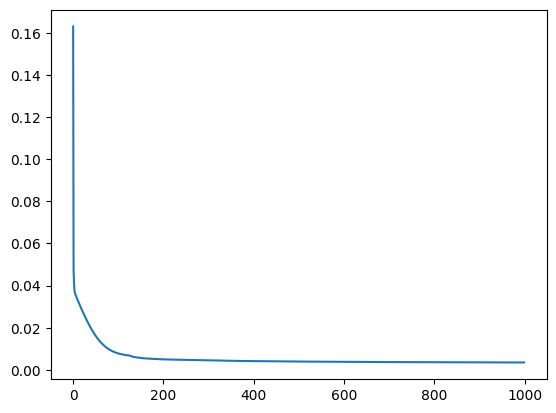

In [41]:
plt.plot(loss_points)
plt.show()

In [42]:
# prediction function, just doing the forward pass
# again (but only that)
def predict(x1, x2):
    input1 = x1
    input2 = x2

    # FORWARD PASS

    # NODE 1 OUTPUT
    node_1_output = input1 * w1 + input2 * w3 + bias1
    node_1_output = activation_ReLu(node_1_output)

    # NODE 2 OUTPUT
    node_2_output = input1 * w2 + input2 * w4 + bias2
    node_2_output = activation_ReLu(node_2_output)

    # NODE 3 OUTPUT
    # we can just use Node 1 and 2 outputs, since they
    # already contain the the previous weights
    node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
    node_3_output = activation_ReLu(node_3_output)

    return node_3_output

In [53]:
# here we can see the expected value is 9
df.iloc[15]

x1    1
x2    6
y     9
Name: 15, dtype: int64

In [54]:
# copy the first two values into the predict()-function below
data[15]

array([0.03846154, 0.23076923, 0.34615385])

In [55]:
# the value tends to be same as final bias3 
# so if node1 and node2 outputs are small => more or less bias3
result = predict(0.03846154, 0.23076923)
result

0.3632144186430953

In [56]:
# convert scaled value back to actual y-value 
# basically multiply the predicted result with max-value of y =>
# get the corresponding y-value
df['y'].max() * result

# the predicted is 9.4, real value is 9
# so the model works fairly ok with x1/x2/y -type of equation data

9.443574884720478